# *Lab*: Multiple Linear Regression for Robot Arm Calibration



In this lab, we will illustrate the use of multiple linear regression for calibrating robot control.  In addition understanding the concepts in the multivariable linear regression demo (with Boston housing data), you will see how to use multiple linear regression for time series data -- an important concept in dynamical systems such as robotics.

The robot data for the lab is taken from the TU Dortmund's Multiple Link Robot Arms Project. As part of the project, they have created an excellent public dataset: [MERIt](http://www.rst.e-technik.tu-dortmund.de/cms/en/research/robotics/TUDOR_engl/index.html#h3MERIt) -- A Multi-Elastic-Link Robot Identification Dataset that can be used for understanding robot dynamics.  The data is from a three link robot:

<img src="https://botzeit.de/wp-content/uploads/2020/01/TUDORBild.png" height="200" width="200">

You can find some [videos](https://www.youtube.com/watch?v=kJPuenyxeps&list=PL1h7jWhj9f_V4MPzf-bNOnI7YzaxArKkb) on YouTube for this robot.

**We will focus on predicting the current draw into one of the joints as a function of the robot motion.  Such models are essential in predicting the overall robot power consumption.  Several other models could also be used.**

### Linear Regression Review
Assume one day you are finding the relationship between temperature and humidity in NYC, and you measured pairs of  temperatures and humidities at different locations

In [3]:
humidities = np.random.uniform(30, 75, 100)
w_0 = 1
w_1 = 1
temperatures = w_1*humidities + w_0 + np.random.normal(loc=0.0, scale=2.0, size=100)

Let's try to fit the data using a line, which means that from the data that we have we want to find a relationship

$$\mathrm{temperatures} = w_0 + w_1 * \mathrm{humidities}$$

what happens if we only have two data points?

$$
y_1 = w_0 + w_1x_1\\
y_2 = w_0 + w_1x_2
$$

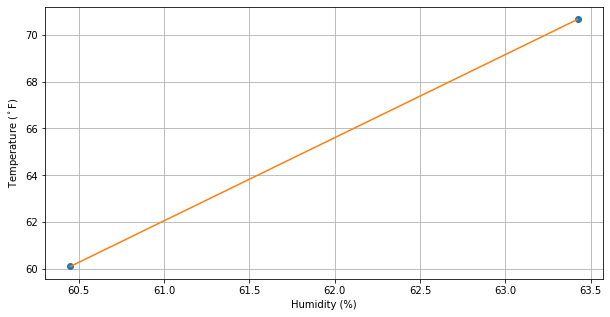

In [4]:
plt.figure(figsize=(10, 5))

# Only two data points
plt.plot([humidities[20], humidities[45]], [temperatures[20], temperatures[45]], 'o')
plt.plot([humidities[20], humidities[45]], [temperatures[20], temperatures[45]])

plt.xlabel("Humidity (%)")
plt.ylabel(r"Temperature ($^\circ$F)")
plt.grid()
plt.show()

what happens if we have 100?

$$
y_1 = w_0 + w_1x_1\\
y_2 = w_0 + w_1x_2\\
\vdots\\
y_{100} = w_0 + w_1x_{100}
$$

we can write

$$y_1 = w_0 + w_1x_1 = \begin{bmatrix}
1 & x_1
\end{bmatrix}\begin{bmatrix}
w_0\\
w_1
\end{bmatrix}$$

similarly we have
$$\begin{bmatrix}
y_1\\
y_2\\
\vdots\\
y_{100}
\end{bmatrix} = \begin{bmatrix}
1 & x_1\\
1 & x_2\\
\vdots & \vdots\\
1 & x_{100}
\end{bmatrix}\begin{bmatrix}
w_0\\
w_1
\end{bmatrix}$$

which for simplicity can be written as $\mathbf{Y} = \mathbf{X}\mathbf{w}$.

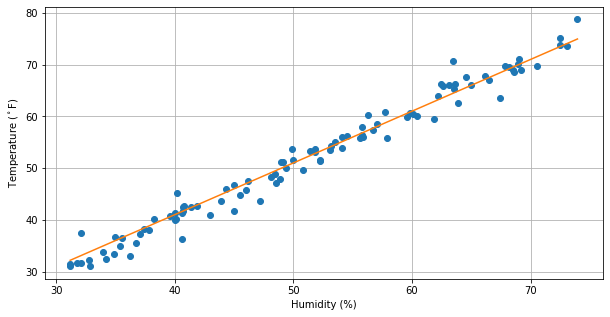

In [5]:
plt.figure(figsize=(10, 5))

# 100 points
plt.plot(humidities, temperatures, 'o')
plt.plot(np.sort(humidities), w_1*np.sort(humidities)+w_0)

plt.xlabel("Humidity (%)")
plt.ylabel(r"Temperature ($^\circ$F)")
plt.grid()
plt.show()

Following the steps
$$\mathbf{Y} = \mathbf{X}\mathbf{w}\\
\mathbf{X}^T\mathbf{Y} = \mathbf{X}^T\mathbf{X}\mathbf{w}\\
\big(\mathbf{X}^T\mathbf{X}\big)^{-1}\mathbf{X}^T\mathbf{Y} = \mathbf{w}
$$
we can find the weights $\mathbf{w}$

In [6]:
temperatures.shape, humidities.shape

((100,), (100,))

$$\begin{bmatrix}
y_1\\
y_2\\
\vdots\\
y_{100}
\end{bmatrix} = \begin{bmatrix}
1 & x_1\\
1 & x_2\\
\vdots & \vdots\\
1 & x_{100}
\end{bmatrix}\begin{bmatrix}
w_0\\
w_1
\end{bmatrix}$$

In [7]:
# first create temperature matrix
Y = np.reshape(temperatures, (100, 1))

# then create the second column of the design matrix
d2 = np.reshape(humidities, (100, 1))

# now create the first column of the design matrix
d1 = np.ones((100, 1))

# stack d1 and d2 horizontally
X = np.hstack((d1, d2))

In [12]:
XTX_inv = np.linalg.inv(X.T @ X)
w = XTX_inv @ X.T @ Y
print(f"estimated w_0: {w[0][0]}\t estimated w_1: {w[1][0]}")
print(f"true w_0: {w_0}\t\t\t\t true w_1: {w_1}")

estimated w_0: -1.2365201470545202	 estimated w_1: 1.0382589825237216
true w_0: 1				 true w_1: 1


In [16]:
X.shape, X.T.shape

((100, 2), (2, 100))

To better see how our estimation is we can calculate the mean squared error, we first see how to calculate the error for one single point $x_0$

In [17]:
idx = 77

x_0 = humidities[idx]
y_0 = temperatures[idx]

y_hat_0 = w[0] + w[1]*x_0

y_diff = y_hat_0 - y_0
print(f"when the humidity is {x_0}, the difference is {y_diff[0]}")

when the humidity is 46.204584331231985, the difference is -0.7953297308413596


we see that the difference can be both positive and negative

the total difference is -1.4061640740692383e-11


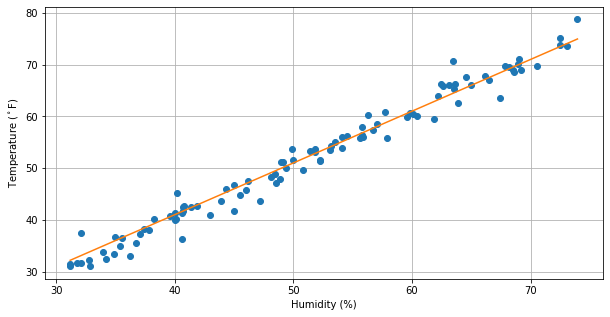

In [18]:
Y_hat = X @ w
Diff = Y_hat - Y
print(f"the total difference is {np.sum(Diff)}")

plt.figure(figsize=(10, 5))

# 100 points
plt.plot(humidities, temperatures, 'o')
plt.plot(np.sort(humidities), w_1*np.sort(humidities)+w_0)

plt.xlabel("Humidity (%)")
plt.ylabel(r"Temperature ($^\circ$F)")
plt.grid()
plt.show()

The reason the total difference is so small is because the positive and negative terms cancelled out, therefore this is not a good measure for error. One way is to the square each of the error terms, which gives you mean squared errors (MSE), 

$$\mathrm{MSE} = \frac{1}{100}\Big\{\big[y_1 - (w_0 + w_1*x_1)\big]^2 + \cdots + \big[y_{100} - (w_0 + w_1*x_{100})\big]^2\Big\} = \frac{1}{100}\sum_{100}^{i=0}{\big[y_i - (w_0 + w_1*x_i)\big]^2}$$

another way is to get the absolute value of the error terms, which gives you the mean absolute error (MAE)

$$\mathrm{MAE} = \frac{1}{100}\Big[\big|y_1 - (w_0 + w_1*x_1)\big| + \cdots + \big|y_{100} - (w_0 + w_1*x_{100})\big|\Big] = \frac{1}{100}\sum_{100}^{i=0}{\big|y_i - (w_0 + w_1*x_i)\big|}$$


In [19]:
w_guess = np.array([[1.1], [1.1]])

Y_hat = X @ w
Diff = Y_hat - Y
mse = np.mean(Diff**2)
mae = np.mean(np.absolute(Diff))

print(f"the MSE is {mse}, the MAE is {mae}")

the MSE is 3.485818383465536, the MAE is 1.3718732530323248


#### Load and Visualize the Data
First, import the modules we will need.

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The full MERIt dataset can be obtained from the [MERIt site](http://www.rst.e-technik.tu-dortmund.de/cms/en/research/robotics/TUDOR_engl/index.html#h3MERIt).  But, this dataset is large. Included in this repository are two of the ten experiments.  Each experiments corresonds to 80 seconds of recorded motion.  

We are going to use the following file:
* [robot_arm.csv](https://raw.githubusercontent.com/BolunDai0216/nyuMLSummerSchool/master/day02/robot_arm.csv) 

Below, we have supplied the column headers in the `names` array.  


In [ ]:
names =[
    't',                                  # Time (secs)
    'q1', 'q2', 'q3',                     # Joint angle   (rads)
    'dq1', 'dq2', 'dq3',                  # Joint velocity (rads/sec)
    'I1', 'I2', 'I3',                     # Motor current (A)
    'eps21', 'eps22', 'eps31', 'eps32',   # Strain gauge measurements ($\mu$m /m )
    'ddq1', 'ddq2', 'ddq3'                # Joint accelerations (rad/sec^2)
]


filename = 'https://raw.githubusercontent.com/BolunDai0216/NYUMLSummerSchool21/main/day02/robot_arm.csv'
df = pd.read_csv(filename, header=None, names=names, delim_whitespace=False, na_values='?')

Print the first six lines of the pandas dataframe and manually check that they match the first rows of the csv file.

In [ ]:
df.head(5)

From the dataframe `df`, extract the *time* values into a vector `t` and extract `I2`, the *current* into the second joint.  Place the *current* in a vector `y`. Plot `y` vs. `t`.   Label the axes with the units.

In [ ]:
# If you want to pick the column 't'
t = df['t'].values

# TODO: do the same thing for I2
y = df['I2'].values


fig = plt.figure()

# TODO: Plot (t, y), t is the x-axis and y is the y-axis
# hint: use plt.plot(**, **)
plt.plot(t, y)


# TODO: label the axis use plt.xlabel("***"), and plt.ylabel("***"), replace *** with the corresponding labels
plt.xlabel("time (sec)")
plt.ylabel("current (amp)")

plt.show()

Let's use all the samples from the dataset that we need to train our model with:

* `y`:  A vector of all the samples from the `I2` column
* `X`:  A matrix of the data with the columns:  `['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']`

In [ ]:
# TODO
# hint: you can choose two columns using: df[['q2','dq2']].values
X = df[['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']].values

#### Fit a Linear Model

Import linear_model from sklearn.

Use the `sklearn.linear_model` module to create a `LinearRegression` class `regr`.

In [ ]:
# Create linear regression object
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

Train the model on the our data.

In [ ]:
# TODO
# hint try lin_reg.fit(data, label)
lin_reg.fit(X, y)

Using the trained model, compute, `y_pred`, the predicted *current*.  Plot `y_pred` vs. time `t`.  On the same plot, plot the actual *current* `ytrain` vs. time `t`.  Create a legend for the plot.

In [ ]:
# TODO
# hint try the predict function see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
y_pred = lin_reg.predict(X)

plt.figure(figsize=(10, 5))
plt.plot(t, y_pred, label="prediction")
plt.plot(t, y, label="ground truth")
plt.legend(frameon=False)
plt.grid()
plt.xlabel("time (sec)")
plt.ylabel("current (amp)")

#### Goodness of the fit

Compute the MSE for your model

In [ ]:
# TODO
# hint: try np.mean() and np.square()
mse = np.mean(np.square(y_pred - y))
print(f"the mse is {mse}")

from sklearn.metrics import mean_squared_error
# hint: also try mean_squared_error(), see the example in https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
mse2 = mean_squared_error(y, y_pred)
print(f"the mse is {mse2}")